In [1]:
!pip install sentence_transformers~=2.2.2

In [2]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

from gensim.utils import simple_preprocess
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, multilabel_confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MultiLabelBinarizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import ADASYN, SMOTE
import seaborn as sns
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.utils import to_categorical

import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import xgboost as xgb

from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data = pd.read_csv('/content/drive/MyDrive/data2.csv')

In [5]:
data.drop(data.columns[data.columns.str.contains('Unnamed')], axis=1, inplace=True)
data = data.drop(['page', 'order', 'id', 'number_of_pages'], axis=1)

In [6]:
data

,category,title,price,weight,author,type,publisher,desc,height,width
0,thieu-nhi,Vườn Nhà Bà - Gà Mái Mơ,50.15,100,Hương Thảo,Bìa Mềm,NXB Dân Trí,"Nâng cao khả năng quan sát, trí tưởng tượng và...",23.0,20.5
1,thieu-nhi,Vở Ô Ly Có Chữ Mẫu Luyện Viết Chữ Đẹp - Nâng C...,10.20,55,"Chính An, Nhóm Giáo Viên ĐHSP",Bìa Mềm,NXB Đồng Nai,"Luyện chữ đẹp, rèn tính nết. Các em chú ý: 1. ...",24.0,17.0
2,thieu-nhi,Em Muốn Biết Vì Sao - Máy Bay Có Cánh (Tái Bản...,33.15,100,Christopher Maynard,Bìa Mềm,NXB Dân Trí,Em muốn biết vì sao bụng em sôi ùng ục? Em muố...,23.0,28.0
3,thieu-nhi,Sticker Dolly Dressing - Dán Hình Sáng Tạo Tra...,46.75,160,"Fiona Watt, Elizabeth Savanella, Jodie Smith",Bìa Mềm,NXB Thanh Niên,Bộ sách giúp bé thỏa sức sáng tạo ra các tác ...,24.0,17.0
4,thieu-nhi,Tớ Là CEO Nhí 2 - Bảo Vệ Tài Sản - Cùng Bé Khá...,27.20,70,True Fruit,Bìa Mềm,NXB Kim Đồng,Bé muốn tìm hiểu các kĩ năng quản lí tài chính...,20.5,19.0
...,...,...,...,...,...,...,...,...,...,...
12519,kinh-te-chinh-tri-phap-ly,Lời Thú Tội Của Một Sát Thủ Kinh Tế - Bìa Cứng...,147.00,546,John Perkins,Bìa Cứng,NXB Dân Trí,Sau thành công của hai ấn bản đầu tiên: (2004...,24.0,16.0
12520,kinh-te-chinh-tri-phap-ly,Bí Mật Tư Duy Triệu Phú (Tái Bản 2021),86.40,300,T Harv Eker,Bìa Mềm,NXB Tổng Hợp TP.HCM,Trong cuốn sách này sẽ tiết lộ những bí mật t...,20.5,14.5
12521,kinh-te-chinh-tri-phap-ly,Chiến Tranh Tiền Tệ - Phần 1 - Ai Thực Sự Là N...,102.30,570,Song Hong Bing,Bìa Mềm,NXB Lao Động,Một khi đọc “Chiến tranh tiền tệ - Ai thật sự ...,24.0,16.0
12522,kinh-te-chinh-tri-phap-ly,Tư Duy Chiến Lược - Lý Thuyết Trò Chơi Thực Hành,115.32,560,"Avinash K. Dixit, Barry J. Nalebuff",Bìa Mềm,NXB Dân Trí,Tư duy chiến lược là nghệ thuật vượt qua đối t...,20.5,14.5


In [7]:
reset_df = data.reset_index(drop=True)

In [8]:
data.category.value_counts()

tam-ly-ky-nang-song            2057
thieu-nhi                      1939
van-hoc-trong-nuoc             1909
giao-khoa-tham-khao            1676
kinh-te-chinh-tri-phap-ly      1296
khoa-hoc-ky-thuat               856
lich-su-dia-ly-ton-giao         841
nuoi-day-con                    707
chinh-tri-phap-ly-triet-hoc     438
tieu-su-hoi-ky                  355
nu-cong-gia-chanh               229
van-hoa-nghe-thuat-du-lich      221
Name: category, dtype: int64

In [9]:
data = data[data['category'] != 'chinh-tri-phap-ly-triet-hoc']
data = data[data['category'] != 'tieu-su-hoi-ky']
data = data[data['category'] != 'nu-cong-gia-chanh']
data = data[data['category'] != 'van-hoa-nghe-thuat-du-lich']

In [10]:
# from pyvi import ViTokenizer
def clean_text(text):
  text = re.sub(r' +', r' ', text)
  text = re.sub(r'[^\w\s]', r'', text)
  text = text.strip().lower()
  return "query: " + text

def segment_text(text):
  return ViTokenizer.tokenize(text)

In [11]:
data['title'] = data['title'].apply(lambda x: clean_text(x))
data['desc'] = data['desc'].apply(lambda x: clean_text(x))
# data['title'] = data['title'].apply(lambda x: segment_text(x))
# data['desc'] = data['desc'].apply(lambda x: segment_text(x))

In [12]:
data['title'][0]

'query: vườn nhà bà  gà mái mơ'

In [13]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('intfloat/multilingual-e5-base', device='cuda')

In [14]:
def embedding_text(df):
  return model.encode(df,show_progress_bar=True,normalize_embeddings=True)

In [15]:
model.max_seq_length = 32
title = embedding_text(data['title'].tolist())
model.max_seq_length = 384
description = embedding_text(data['desc'].tolist())

Batches:   0%|          | 0/353 [00:00<?, ?it/s]

Batches:   0%|          | 0/353 [00:00<?, ?it/s]

In [16]:
print(title[0].tolist())

[0.007161332294344902, 0.03820877894759178, -0.01762322522699833, 0.005018297582864761, 0.01399625651538372, -0.010816705413162708, -0.004592008423060179, -0.045619405806064606, -0.018355704843997955, 0.018265491351485252, -0.014180926606059074, -0.010876973159611225, 0.21531914174556732, 0.009605650790035725, -0.048906125128269196, -0.040962737053632736, 0.029547495767474174, -0.030050130560994148, 0.0025531684514135122, 0.015801172703504562, 0.020275169983506203, 0.006227195728570223, 0.03416422754526138, -0.03185225650668144, 0.03537822514772415, -0.023104172199964523, 0.0016845996724441648, 0.04815400391817093, -0.013565704226493835, 0.021066678687930107, 0.021524978801608086, -0.02234034426510334, 0.030488507822155952, 0.004218543879687786, 0.06522781401872635, 0.0029976896476000547, -0.04178526997566223, -0.013592975214123726, 0.05852966755628586, 0.016494670882821083, -0.005922506097704172, -0.0013208845630288124, 0.008756488561630249, -0.015250434167683125, 0.003102847374975681

In [17]:
pub_encoder = LabelEncoder()
pub_encoder.fit(data.publisher)
data['embeded_pub'] =  pub_encoder.transform(data.publisher)

In [18]:
data_ = data[['price', 'weight', 'height', 'width', 'embeded_pub']]

In [19]:
le = LabelEncoder()
le.fit(data["category"])
data["norm_label"] = le.transform(data["category"])

In [20]:
print(le.classes_)

['giao-khoa-tham-khao' 'khoa-hoc-ky-thuat' 'kinh-te-chinh-tri-phap-ly'
 'lich-su-dia-ly-ton-giao' 'nuoi-day-con' 'tam-ly-ky-nang-song'
 'thieu-nhi' 'van-hoc-trong-nuoc']


In [21]:
scaler = StandardScaler()
scaler.fit(data_[['price', 'height', 'width', 'embeded_pub']])
df_scaled = scaler.transform(data_[['price', 'height', 'width', 'embeded_pub']])

In [29]:
data1 = []
for idx in range(11281):
  v2, v3 =  title[idx].tolist() , description[idx].tolist()
  data1.append(v2+v3)
  # data1.append(data_.iloc[idx]['embeded_desc'].tolist()[0])

In [30]:
print(len(data1[0]))
X = pd.DataFrame(data1)
y = data['norm_label'].values.reshape(-1,1)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

1536


In [24]:
fold_indices = []
for train_index, test_index in skf.split(X, y):
    fold_indices.append((train_index, test_index))

In [31]:
train_index, test_index = fold_indices[4]
train_data, test_data = X.loc[train_index], X.loc[test_index]
train_labels, test_labels = y[train_index], y[test_index]

In [42]:
khkt_index = reset_df[reset_df['category'] == 'khoa-hoc-ky-thuat'].index
lsdl_index = reset_df[reset_df['category'] == 'lich-su-dia-ly-ton-giao'].index

# XGB Boost

In [ ]:

xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=8, random_state=42)
xgb_classifier.fit(train_data, train_labels)
y_pred = xgb_classifier.predict(test_data)
accuracy = accuracy_score(test_labels, y_pred)
classification_report_str = classification_report(le.inverse_transform(test_labels), le.inverse_transform(y_pred))
print(f"Accuracy: {accuracy:.4f}")
print(classification_report_str)


Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x7e75f2c6da80>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 589, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument
KeyboardInterrupt: 


[0]	validation_0-merror:0.21418	validation_0-mlogloss:1.49265	validation_1-merror:0.38076	validation_1-mlogloss:1.64286
[1]	validation_0-merror:0.13884	validation_0-mlogloss:1.18516	validation_1-merror:0.33023	validation_1-mlogloss:1.42435
[2]	validation_0-merror:0.10504	validation_0-mlogloss:0.97323	validation_1-merror:0.31383	validation_1-mlogloss:1.27307
[3]	validation_0-merror:0.08199	validation_0-mlogloss:0.80905	validation_1-merror:0.29078	validation_1-mlogloss:1.15668
[4]	validation_0-merror:0.06471	validation_0-mlogloss:0.68165	validation_1-merror:0.27704	validation_1-mlogloss:1.06468
[5]	validation_0-merror:0.05463	validation_0-mlogloss:0.57943	validation_1-merror:0.26729	validation_1-mlogloss:0.99257
[6]	validation_0-merror:0.04310	validation_0-mlogloss:0.49578	validation_1-merror:0.25665	validation_1-mlogloss:0.92888
[7]	validation_0-merror:0.03302	validation_0-mlogloss:0.42643	validation_1-merror:0.24911	validation_1-mlogloss:0.87613
[8]	validation_0-merror:0.02637	validati

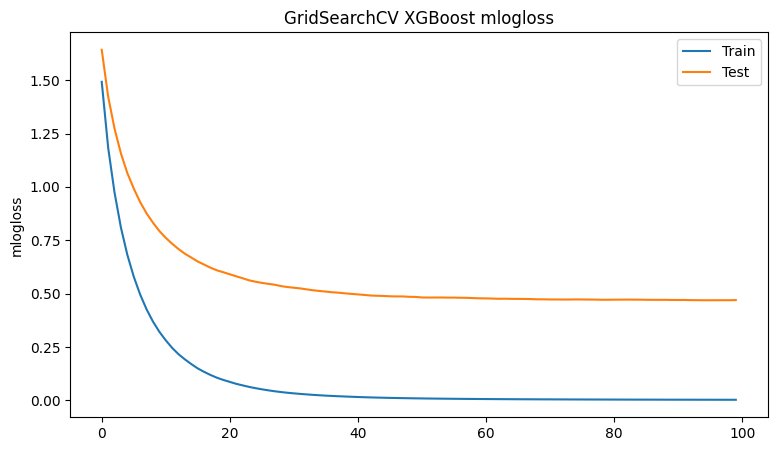

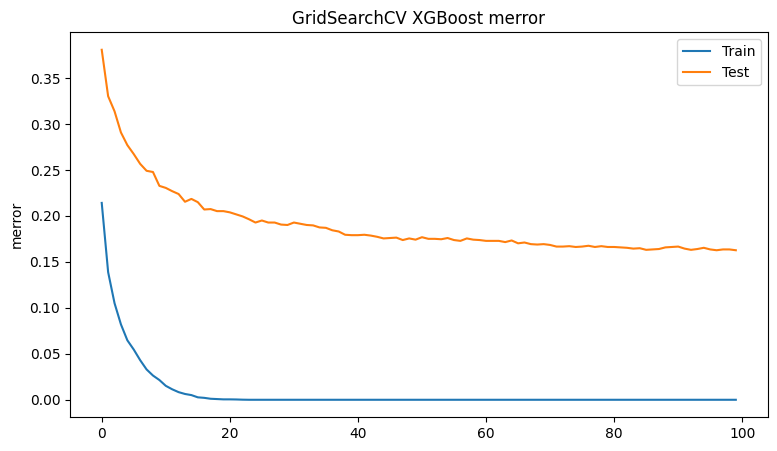

In [32]:
xgb_v1 = xgb.XGBClassifier(objective='multi:softmax',
                            num_class=8,
                            missing=1,
                            early_stopping_rounds=10,
                            eval_metric=['merror','mlogloss'],
                            seed=42)
xgb_v1.fit(train_data, train_labels,
           eval_set=[(train_data, train_labels), (test_data, test_labels)])
results = xgb_v1.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('GridSearchCV XGBoost merror')
plt.show()

[0]	validation_0-merror:0.38172	validation_0-mlogloss:1.94473	validation_1-merror:0.41002	validation_1-mlogloss:1.95382
[1]	validation_0-merror:0.34017	validation_0-mlogloss:1.83512	validation_1-merror:0.37456	validation_1-mlogloss:1.85323
[2]	validation_0-merror:0.31778	validation_0-mlogloss:1.74291	validation_1-merror:0.35239	validation_1-mlogloss:1.76875
[3]	validation_0-merror:0.29651	validation_0-mlogloss:1.65984	validation_1-merror:0.33777	validation_1-mlogloss:1.69163
[4]	validation_0-merror:0.28532	validation_0-mlogloss:1.58594	validation_1-merror:0.33422	validation_1-mlogloss:1.62385
[5]	validation_0-merror:0.27191	validation_0-mlogloss:1.52004	validation_1-merror:0.31472	validation_1-mlogloss:1.56415
[6]	validation_0-merror:0.26482	validation_0-mlogloss:1.46132	validation_1-merror:0.30762	validation_1-mlogloss:1.50902
[7]	validation_0-merror:0.25651	validation_0-mlogloss:1.40782	validation_1-merror:0.30275	validation_1-mlogloss:1.45989
[8]	validation_0-merror:0.24920	validati

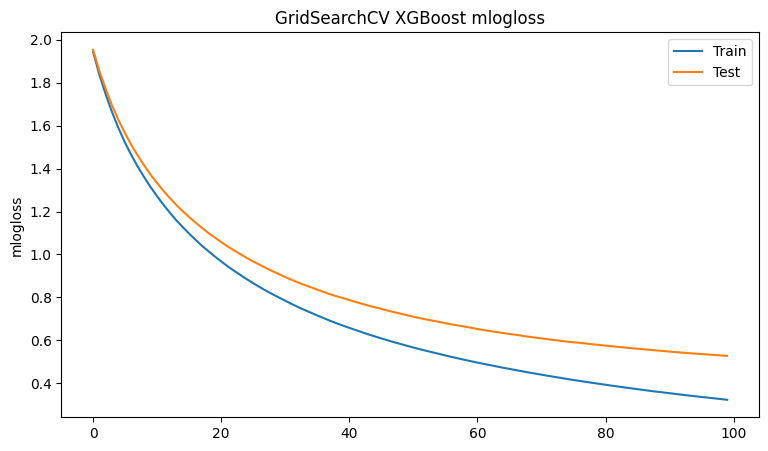

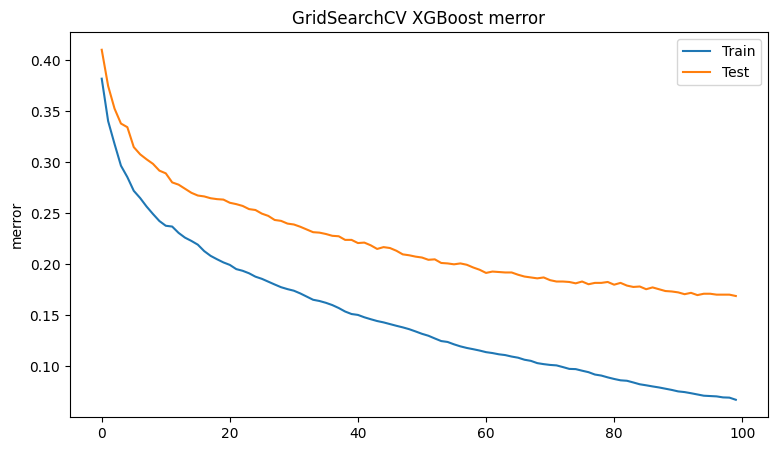

In [51]:
xgb_v2 = xgb.XGBClassifier(objective='multi:softmax',
                            num_class=8,
                            missing=1,
                            gamma=0, # default gamma value
                            learning_rate=0.1,
                            max_depth=3,
                            reg_lambda=1, # default L2 value
                            subsample=1, # default subsample value
                            colsample_bytree=1, # default colsample_bytree value
                            early_stopping_rounds=10,
                            eval_metric=['merror','mlogloss'],
                            seed=42)

xgb_v2.fit(train_data, train_labels,
           eval_set=[(train_data, train_labels), (test_data, test_labels)])
results = xgb_v2.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('GridSearchCV XGBoost merror')
plt.show()

In [33]:
pred = xgb_v1.predict(test_data)
accuracy = accuracy_score(test_labels, pred)
classification_report_str = classification_report(le.inverse_transform(test_labels), le.inverse_transform(pred))
print(f"Accuracy: {accuracy:.4f}")
print(classification_report_str)

Accuracy: 0.8347
                           precision    recall  f1-score   support

      giao-khoa-tham-khao       0.97      0.96      0.96       336
        khoa-hoc-ky-thuat       0.87      0.67      0.75       171
kinh-te-chinh-tri-phap-ly       0.83      0.85      0.84       259
  lich-su-dia-ly-ton-giao       0.76      0.67      0.71       168
             nuoi-day-con       0.88      0.85      0.86       142
      tam-ly-ky-nang-song       0.74      0.80      0.77       412
                thieu-nhi       0.86      0.85      0.86       387
       van-hoc-trong-nuoc       0.81      0.88      0.85       381

                 accuracy                           0.83      2256
                macro avg       0.84      0.81      0.82      2256
             weighted avg       0.84      0.83      0.83      2256



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [44]:
khkt = X.loc[khkt_index]
khkt_pred = xgb_v2.predict(khkt)
x1 = le.inverse_transform(khkt_pred)

In [45]:
from collections import Counter
counter_x1 = Counter(x1)
for element, count in counter_x1.items():
    print(f"{element}: {count} times")

khoa-hoc-ky-thuat: 695 times
tam-ly-ky-nang-song: 78 times
kinh-te-chinh-tri-phap-ly: 16 times
van-hoc-trong-nuoc: 12 times
thieu-nhi: 22 times
lich-su-dia-ly-ton-giao: 11 times
nuoi-day-con: 8 times
giao-khoa-tham-khao: 14 times


In [46]:
for index, item in enumerate(x1):
  if item == 'tam-ly-ky-nang-song':
    print(reset_df.loc[khkt_index[index]])

category                                       khoa-hoc-ky-thuat
title           query: khái niệm then chốt trong nghiên cứu giới
price                                                      142.8
weight                                                       500
author                             Jane Pilcher, Imelda Whelehan
type                                                     Bìa Mềm
publisher                                    NXB Phụ Nữ Việt Nam
desc           query: khái niệm then chốt trong nghiên cứu gi...
height                                                      24.0
width                                                       15.0
embeded_pub                                                   25
norm_label                                                     1
Name: 3640, dtype: object
category                                       khoa-hoc-ky-thuat
title                                  query: toán không hề ngán
price                                                     101.15

In [ ]:
lsdl = X.loc[lsdl_index]
lsdl_pred = xgb_classifier.predict(lsdl)
x2 = le.inverse_transform(lsdl_pred)
counter_x2 = Counter(x2)
for element, count in counter_x2.items():
    print(f"{element}: {count} times")

In [ ]:
for index, item in enumerate(x2):
  if item == 'tam-ly-ky-nang-song':
    print(reset_df.loc[lsdl_index[index]])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


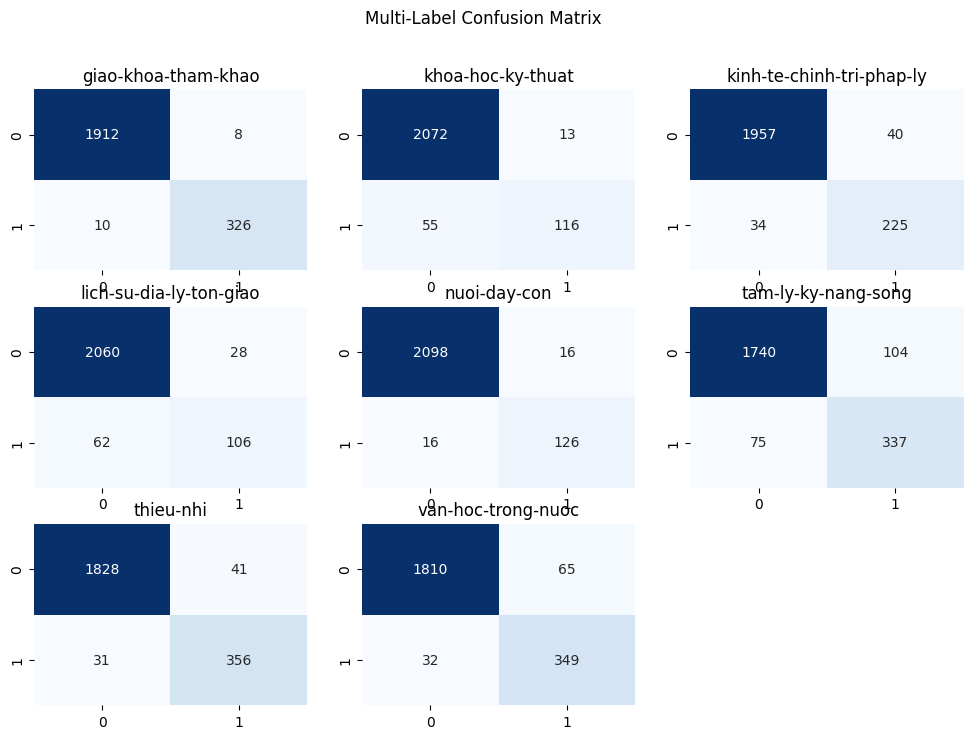

In [ ]:
mlb = MultiLabelBinarizer()
y_test_bin = mlb.fit_transform(le.inverse_transform(test_labels))
y_pred_bin = mlb.transform(le.inverse_transform(y_pred))
mcm = multilabel_confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(12, 8))
for i in range(mcm.shape[0]):
    plt.subplot(3, 3, i + 1)
    sns.heatmap(mcm[i], annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.title(le.classes_[i])

plt.suptitle('Multi-Label Confusion Matrix')
plt.show()


# **RandomForrest**

In [26]:
for index, (train_index, test_index) in enumerate(skf.split(X, y)):
  print(f"Fold: {index}")
  train_data, test_data = X.loc[train_index], X.loc[test_index]
  train_labels, test_labels = y[train_index], y[test_index]
  rf = RandomForestClassifier(n_estimators=100, random_state=42)
  rf.fit(train_data, train_labels)
  y_pred = rf.predict(test_data)
  accuracy = accuracy_score(test_labels, y_pred)
  classification_report_str = classification_report(le.inverse_transform(test_labels), le.inverse_transform(y_pred))
  print(f"Accuracy: {accuracy:.4f}")
  print(classification_report_str)


Fold: 0


<ipython-input-26-42cc67ec3002>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(train_data, train_labels)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.8082
                           precision    recall  f1-score   support

      giao-khoa-tham-khao       0.93      0.99      0.96       335
        khoa-hoc-ky-thuat       0.96      0.43      0.60       171
kinh-te-chinh-tri-phap-ly       0.83      0.82      0.82       259
  lich-su-dia-ly-ton-giao       0.94      0.43      0.59       168
             nuoi-day-con       0.98      0.73      0.83       142
      tam-ly-ky-nang-song       0.63      0.82      0.72       412
                thieu-nhi       0.87      0.90      0.89       388
       van-hoc-trong-nuoc       0.76      0.90      0.83       382

                 accuracy                           0.81      2257
                macro avg       0.86      0.75      0.78      2257
             weighted avg       0.83      0.81      0.80      2257

Fold: 1


<ipython-input-26-42cc67ec3002>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(train_data, train_labels)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-26-42cc67ec3002>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(train_data, train_labels)


Accuracy: 0.7668
                           precision    recall  f1-score   support

      giao-khoa-tham-khao       0.92      0.98      0.95       335
        khoa-hoc-ky-thuat       0.94      0.40      0.56       171
kinh-te-chinh-tri-phap-ly       0.75      0.78      0.77       259
  lich-su-dia-ly-ton-giao       0.90      0.38      0.53       169
             nuoi-day-con       0.89      0.66      0.76       141
      tam-ly-ky-nang-song       0.63      0.76      0.69       411
                thieu-nhi       0.83      0.82      0.83       388
       van-hoc-trong-nuoc       0.69      0.90      0.78       382

                 accuracy                           0.77      2256
                macro avg       0.82      0.71      0.73      2256
             weighted avg       0.79      0.77      0.76      2256

Fold: 2


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.7722
                           precision    recall  f1-score   support

      giao-khoa-tham-khao       0.93      0.97      0.95       335
        khoa-hoc-ky-thuat       0.96      0.40      0.57       171
kinh-te-chinh-tri-phap-ly       0.83      0.81      0.82       260
  lich-su-dia-ly-ton-giao       0.87      0.37      0.52       168
             nuoi-day-con       0.95      0.58      0.72       141
      tam-ly-ky-nang-song       0.60      0.80      0.69       411
                thieu-nhi       0.83      0.84      0.84       388
       van-hoc-trong-nuoc       0.69      0.89      0.78       382

                 accuracy                           0.77      2256
                macro avg       0.83      0.71      0.74      2256
             weighted avg       0.80      0.77      0.76      2256

Fold: 3


<ipython-input-26-42cc67ec3002>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(train_data, train_labels)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-26-42cc67ec3002>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(train_data, train_labels)


Accuracy: 0.7859
                           precision    recall  f1-score   support

      giao-khoa-tham-khao       0.95      0.98      0.96       335
        khoa-hoc-ky-thuat       0.91      0.36      0.52       172
kinh-te-chinh-tri-phap-ly       0.82      0.80      0.81       259
  lich-su-dia-ly-ton-giao       0.91      0.45      0.60       168
             nuoi-day-con       0.94      0.67      0.78       141
      tam-ly-ky-nang-song       0.61      0.81      0.70       411
                thieu-nhi       0.82      0.85      0.83       388
       van-hoc-trong-nuoc       0.75      0.90      0.82       382

                 accuracy                           0.79      2256
                macro avg       0.84      0.73      0.75      2256
             weighted avg       0.81      0.79      0.78      2256

Fold: 4
Accuracy: 0.8059
                           precision    recall  f1-score   support

      giao-khoa-tham-khao       0.96      0.99      0.97       336
        khoa-hoc

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# **Neural Network**

In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import BatchNormalization, Dropout

In [31]:
epochs = 20
batch_size = 32
encoder = OneHotEncoder(sparse=False)

for index, (train_index, test_index) in enumerate(skf.split(X, y)):
  print(f"Fold: {index}")
  nn_model = models.Sequential()
  nn_model.add(layers.InputLayer(input_shape=(1541,)))
  # nn_model.add(BatchNormalization())
  nn_model.add(layers.Dense(512, activation='relu')) #, kernel_regularizer=regularizers.l2(0.01)
  nn_model.add(BatchNormalization())
  nn_model.add(layers.Dense(256, activation='relu')) #, kernel_regularizer=regularizers.l2(0.01)
  # nn_model.add(Dropout(0.5))
  nn_model.add(layers.Dense(8, activation='softmax'))
  nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Split the data into training and testing sets

  train_data, test_data = X.loc[train_index], X.loc[test_index]
  train_labels, test_labels = encoder.fit_transform(y[train_index].reshape(-1, 1)), encoder.transform(y[test_index].reshape(-1, 1))
  history = nn_model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(test_data, test_labels), verbose=1)

  y_pred_encoded = nn_model.predict(test_data)

  # Convert one-hot encoded predictions to labels
  y_pred = np.argmax(y_pred_encoded, axis=1)

  # Convert one-hot encoded ground truth to labels
  y_true = np.argmax(test_labels, axis=1)

  # Print classification report
  print(classification_report(y_true, y_pred, target_names=list(le.classes_)))


Fold: 0


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/20
282/282 [==============================] - 4s 6ms/step - loss: 0.6678 - accuracy: 0.7750 - val_loss: 0.8941 - val_accuracy: 0.8192
Epoch 2/20
282/282 [==============================] - 2s 6ms/step - loss: 0.3848 - accuracy: 0.8665 - val_loss: 0.4238 - val_accuracy: 0.8471
Epoch 3/20
282/282 [==============================] - 2s 6ms/step - loss: 0.2908 - accuracy: 0.8953 - val_loss: 0.4823 - val_accuracy: 0.8396
Epoch 4/20
282/282 [==============================] - 1s 4ms/step - loss: 0.2176 - accuracy: 0.9235 - val_loss: 0.4696 - val_accuracy: 0.8551
Epoch 5/20
282/282 [==============================] - 1s 5ms/step - loss: 0.1675 - accuracy: 0.9402 - val_loss: 0.5084 - val_accuracy: 0.8516
Epoch 6/20
282/282 [==============================] - 1s 4ms/step - loss: 0.1117 - accuracy: 0.9629 - val_loss: 0.5679 - val_accuracy: 0.8427
Epoch 7/20
282/282 [==============================] - 1s 5ms/step - loss: 0.0894 - accuracy: 0.9681 - val_loss: 0.6394 - val_accuracy: 0.8418
Epoch 

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/20
283/283 [==============================] - 3s 8ms/step - loss: 0.6467 - accuracy: 0.7807 - val_loss: 0.8523 - val_accuracy: 0.7899
Epoch 2/20
283/283 [==============================] - 2s 7ms/step - loss: 0.3722 - accuracy: 0.8688 - val_loss: 0.4907 - val_accuracy: 0.8307
Epoch 3/20
283/283 [==============================] - 2s 6ms/step - loss: 0.2707 - accuracy: 0.9040 - val_loss: 0.5396 - val_accuracy: 0.8240
Epoch 4/20
283/283 [==============================] - 1s 5ms/step - loss: 0.2096 - accuracy: 0.9233 - val_loss: 0.6038 - val_accuracy: 0.8236
Epoch 5/20
283/283 [==============================] - 2s 5ms/step - loss: 0.1518 - accuracy: 0.9460 - val_loss: 0.5946 - val_accuracy: 0.8347
Epoch 6/20
283/283 [==============================] - 1s 5ms/step - loss: 0.1241 - accuracy: 0.9576 - val_loss: 0.7170 - val_accuracy: 0.8227
Epoch 7/20
283/283 [==============================] - 1s 5ms/step - loss: 0.0973 - accuracy: 0.9681 - val_loss: 0.7103 - val_accuracy: 0.8271
Epoch 

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/20
283/283 [==============================] - 4s 8ms/step - loss: 0.6470 - accuracy: 0.7822 - val_loss: 0.8908 - val_accuracy: 0.7824
Epoch 2/20
283/283 [==============================] - 2s 7ms/step - loss: 0.3752 - accuracy: 0.8695 - val_loss: 0.5106 - val_accuracy: 0.8196
Epoch 3/20
283/283 [==============================] - 3s 10ms/step - loss: 0.2764 - accuracy: 0.9057 - val_loss: 0.5815 - val_accuracy: 0.8183
Epoch 4/20
283/283 [==============================] - 2s 6ms/step - loss: 0.2084 - accuracy: 0.9242 - val_loss: 0.5428 - val_accuracy: 0.8395
Epoch 5/20
283/283 [==============================] - 2s 5ms/step - loss: 0.1477 - accuracy: 0.9478 - val_loss: 0.5710 - val_accuracy: 0.8555
Epoch 6/20
283/283 [==============================] - 1s 5ms/step - loss: 0.1240 - accuracy: 0.9560 - val_loss: 0.6521 - val_accuracy: 0.8369
Epoch 7/20
283/283 [==============================] - 1s 5ms/step - loss: 0.0974 - accuracy: 0.9673 - val_loss: 0.7393 - val_accuracy: 0.8129
Epoch

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/20
283/283 [==============================] - 3s 6ms/step - loss: 0.6573 - accuracy: 0.7774 - val_loss: 0.8736 - val_accuracy: 0.8254
Epoch 2/20
283/283 [==============================] - 1s 5ms/step - loss: 0.3811 - accuracy: 0.8657 - val_loss: 0.4606 - val_accuracy: 0.8391
Epoch 3/20
283/283 [==============================] - 1s 5ms/step - loss: 0.2748 - accuracy: 0.9019 - val_loss: 0.5236 - val_accuracy: 0.8391
Epoch 4/20
283/283 [==============================] - 1s 5ms/step - loss: 0.2146 - accuracy: 0.9190 - val_loss: 0.5098 - val_accuracy: 0.8480
Epoch 5/20
283/283 [==============================] - 1s 5ms/step - loss: 0.1601 - accuracy: 0.9416 - val_loss: 0.5377 - val_accuracy: 0.8511
Epoch 6/20
283/283 [==============================] - 1s 5ms/step - loss: 0.1198 - accuracy: 0.9602 - val_loss: 0.5463 - val_accuracy: 0.8400
Epoch 7/20
283/283 [==============================] - 2s 6ms/step - loss: 0.0996 - accuracy: 0.9663 - val_loss: 0.6186 - val_accuracy: 0.8333
Epoch 

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/20
283/283 [==============================] - 3s 6ms/step - loss: 0.6621 - accuracy: 0.7789 - val_loss: 0.9220 - val_accuracy: 0.7965
Epoch 2/20
283/283 [==============================] - 1s 5ms/step - loss: 0.3821 - accuracy: 0.8639 - val_loss: 0.4476 - val_accuracy: 0.8475
Epoch 3/20
283/283 [==============================] - 2s 5ms/step - loss: 0.2863 - accuracy: 0.8994 - val_loss: 0.4317 - val_accuracy: 0.8533
Epoch 4/20
283/283 [==============================] - 2s 6ms/step - loss: 0.2100 - accuracy: 0.9209 - val_loss: 0.5163 - val_accuracy: 0.8382
Epoch 5/20
283/283 [==============================] - 2s 7ms/step - loss: 0.1545 - accuracy: 0.9478 - val_loss: 0.5295 - val_accuracy: 0.8435
Epoch 6/20
283/283 [==============================] - 2s 8ms/step - loss: 0.1337 - accuracy: 0.9532 - val_loss: 0.5637 - val_accuracy: 0.8480
Epoch 7/20
283/283 [==============================] - 3s 10ms/step - loss: 0.0970 - accuracy: 0.9654 - val_loss: 0.5799 - val_accuracy: 0.8444
Epoch

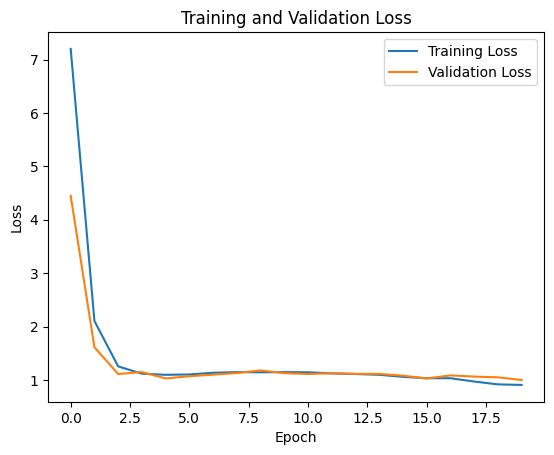

In [ ]:
import matplotlib.pyplot as plt

# Plot training loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred_encoded = nn_model.predict(test_data)

# Convert one-hot encoded predictions to labels
y_pred = np.argmax(y_pred_encoded, axis=1)

# Convert one-hot encoded ground truth to labels
y_true = np.argmax(test_labels, axis=1)

# Print classification report
print(classification_report(y_true, y_pred, target_names=list(le.classes_)))

71/71 [==============================] - 0s 2ms/step
                           precision    recall  f1-score   support

      giao-khoa-tham-khao       0.94      0.98      0.96       336
        khoa-hoc-ky-thuat       0.84      0.67      0.75       171
kinh-te-chinh-tri-phap-ly       0.83      0.91      0.87       259
  lich-su-dia-ly-ton-giao       0.81      0.67      0.73       168
             nuoi-day-con       0.82      0.86      0.84       142
      tam-ly-ky-nang-song       0.75      0.77      0.76       412
                thieu-nhi       0.92      0.84      0.88       387
       van-hoc-trong-nuoc       0.81      0.89      0.85       381

                 accuracy                           0.84      2256
                macro avg       0.84      0.82      0.83      2256
             weighted avg       0.84      0.84      0.84      2256



In [27]:
for index, (train_index, test_index) in enumerate(skf.split(X, y)):
  print(f"Fold: {index}")
  train_data, test_data = X.loc[train_index], X.loc[test_index]
  train_labels, test_labels = y[train_index], y[test_index]
  lr_model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
  lr_model.fit(train_data, train_labels)
  pred = lr_model.predict(test_data)
  accuracy = accuracy_score(test_labels, pred)
  print(f"Accuracy: {accuracy:.4f}")
  print(classification_report(test_labels, pred, target_names=list(le.classes_)))

Fold: 0


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.8445
                           precision    recall  f1-score   support

      giao-khoa-tham-khao       0.94      0.98      0.96       335
        khoa-hoc-ky-thuat       0.84      0.68      0.75       171
kinh-te-chinh-tri-phap-ly       0.88      0.89      0.88       259
  lich-su-dia-ly-ton-giao       0.78      0.67      0.72       168
             nuoi-day-con       0.88      0.84      0.86       142
      tam-ly-ky-nang-song       0.78      0.80      0.79       412
                thieu-nhi       0.85      0.86      0.85       388
       van-hoc-trong-nuoc       0.82      0.88      0.85       382

                 accuracy                           0.84      2257
                macro avg       0.84      0.82      0.83      2257
             weighted avg       0.84      0.84      0.84      2257

Fold: 1


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.8329
                           precision    recall  f1-score   support

      giao-khoa-tham-khao       0.95      0.96      0.95       335
        khoa-hoc-ky-thuat       0.86      0.69      0.77       171
kinh-te-chinh-tri-phap-ly       0.84      0.88      0.86       259
  lich-su-dia-ly-ton-giao       0.74      0.68      0.71       169
             nuoi-day-con       0.80      0.80      0.80       141
      tam-ly-ky-nang-song       0.79      0.79      0.79       411
                thieu-nhi       0.86      0.82      0.84       388
       van-hoc-trong-nuoc       0.79      0.89      0.84       382

                 accuracy                           0.83      2256
                macro avg       0.83      0.81      0.82      2256
             weighted avg       0.83      0.83      0.83      2256

Fold: 2


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.8324
                           precision    recall  f1-score   support

      giao-khoa-tham-khao       0.94      0.95      0.94       335
        khoa-hoc-ky-thuat       0.83      0.67      0.74       171
kinh-te-chinh-tri-phap-ly       0.85      0.85      0.85       260
  lich-su-dia-ly-ton-giao       0.77      0.70      0.73       168
             nuoi-day-con       0.88      0.77      0.82       141
      tam-ly-ky-nang-song       0.74      0.80      0.77       411
                thieu-nhi       0.84      0.87      0.86       388
       van-hoc-trong-nuoc       0.83      0.87      0.85       382

                 accuracy                           0.83      2256
                macro avg       0.84      0.81      0.82      2256
             weighted avg       0.83      0.83      0.83      2256

Fold: 3


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.8488
                           precision    recall  f1-score   support

      giao-khoa-tham-khao       0.96      0.96      0.96       335
        khoa-hoc-ky-thuat       0.80      0.74      0.77       172
kinh-te-chinh-tri-phap-ly       0.88      0.82      0.85       259
  lich-su-dia-ly-ton-giao       0.79      0.76      0.77       168
             nuoi-day-con       0.90      0.79      0.84       141
      tam-ly-ky-nang-song       0.75      0.83      0.78       411
                thieu-nhi       0.90      0.86      0.88       388
       van-hoc-trong-nuoc       0.84      0.89      0.86       382

                 accuracy                           0.85      2256
                macro avg       0.85      0.83      0.84      2256
             weighted avg       0.85      0.85      0.85      2256

Fold: 4


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.8466
                           precision    recall  f1-score   support

      giao-khoa-tham-khao       0.95      0.96      0.96       336
        khoa-hoc-ky-thuat       0.90      0.68      0.77       171
kinh-te-chinh-tri-phap-ly       0.87      0.88      0.87       259
  lich-su-dia-ly-ton-giao       0.78      0.62      0.69       168
             nuoi-day-con       0.89      0.82      0.85       142
      tam-ly-ky-nang-song       0.76      0.82      0.79       412
                thieu-nhi       0.85      0.88      0.86       387
       van-hoc-trong-nuoc       0.83      0.91      0.87       381

                 accuracy                           0.85      2256
                macro avg       0.85      0.82      0.83      2256
             weighted avg       0.85      0.85      0.84      2256

